### Website for plot comparisons:
http://www.astro.utu.fi/~cflynn/galdyn/lecture4.html

# Imports 

In [18]:
import sympy as sp
import numpy as np
from sympy import init_printing
from sympy.abc import rho,sigma,G, pi,phi
import pprint
init_printing() 
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['axes.linewidth'] = 2


### Constants  

In [19]:
G_cgs     = 6.67e-8 # grav constant
k_boltz_cgs   = 1.380649e-16
solar_mass_cgs = 2e33 #grams
solar_temp_cgs = 5778 #Kelvin

### Symbolic math for isothermal sphere density & potentials, to put into functions.. 

In [20]:
r = sp.symbols('r')
expr_rho = pow(sigma,2) / (2* pi*G*pow(r,2))
rho_eq = sp.Eq(rho, expr_rho)

expr_2   = pow(sigma,2) / ((2* pi*G))
expr_phi = sp.Mul(sp.exp( ( (4 * G * pi ) / (sigma ** 2)) * phi )) * expr_2 
rho_eq_2 = sp.Eq(rho, expr_phi)

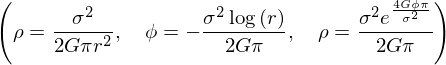

In [21]:
rho_first_int = sp.integrate(expr_rho, r)
phi_eq = sp.integrate(rho_first_int, r)
phi_eq = sp.Eq(phi, phi_eq)
rho_eq, phi_eq, rho_eq_2

### Misc Functions; derivatives (df_dr & d2f_dr2) calc + Poisson solver for rho

In [22]:
# Take derivative of function (an array that is a function of x) W.R.T x
def take_deriv(_function_array, _x, _n=1, _deriv_func=np.gradient):
    """
    This function can return up to the 2nd derivative of a function f(x) W.R.T x ; df /dx or d2f/d2x
    _function_array = f(x) (array)
    _x = x                 (array that was passed to f)
    _order= int, up to 2nd order
    _deriv_func = np.gradient
    returns NP ARRAY of ((_x),(d^nf(x)/dx^n)}) with shape (length of _x , 2)
    """
    if _n > 2:
        raise ValueError(
            "This function does not compute n>2 order derivatives")
    if _deriv_func != np.gradient:
        raise ValueError(
            "This function only uses np.gradient to compute derivatives")
    # np.gradient
    if _deriv_func == np.gradient:
        # First derivative
        _df_of_x_first = _deriv_func(_function_array)
        _d_x_first = _deriv_func(_x)
        _desired_deriv = _df_of_x_first/_d_x_first
        _x_output = _x
        # Second derivative
        if _n == 2:
            _df_of_x_second = _deriv_func(_df_of_x_first)
            _d_x_second = _deriv_func(_d_x_first)
            _desired_deriv = _df_of_x_second/_d_x_second

    return np.array((_x_output, _desired_deriv))


def rho_solver_for_phi_of_r_poisson(_r, _phi_func, _deriv_func=take_deriv, _k_boltz=1, _Grav_const=1,
                                    _mean_mass=1, _temp=1, _a_plum=1, _M=1):
    """
    This function takes as input:
    input array _r (radius)
    deriv_funct = the above derivative function
    the rest are constants

    Outputs an array containing the inputs _r and numerical rho(r); shape (len(_r),2)

    _normalize determines whethr or not you want numerical rho to be normalized by the analytic
    expression
    if true the outputs become are still _r and numerical rho(r) but the shape is now:
    
    (len(_r[np.isfinite(numerical rho(r))]),2)
    
    this is done because this phi/rho functions currently blow up close to 0 due to logs/exponentials


    """
    _RHS_constants = (4.0*np.pi*_Grav_const)
    # make derivative pieces
    # iso sphere
    if _phi_func == phi_iso_sphere_of_r_analytic:
        _, _d_phi_dr = _deriv_func(_phi_func(_r, _k_boltz=_k_boltz, _Grav_const=_Grav_const,
                                             _mean_mass=_mean_mass, _temp=_temp), _r, _n=1)
    # plum sphere
    if _phi_func == phi_plum_sphere_of_r_analytic:
        _, _d_phi_dr = _deriv_func(
            _phi_func(_r, _Grav_const=1, _M=1), _r, _n=1)

    # start calcs
    first_term = (_r**2.0) * _d_phi_dr
    _, outer_derive = _deriv_func(_d_phi_dr, _r, _n=1)
    # LHS of Poisson EQ
    _LHS = (_r**-2.0) * outer_derive
    _calc = _LHS / _RHS_constants
    return np.array((_r, _calc))

### Analytic Isothermal Sphere Functions 

In [23]:
# ISOTHERMAL SPHERE ##### PHI (r) ### ANALYTIC EQ
def phi_iso_sphere_of_r_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1):
    _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
    calc = (((_sigma ** 2.0) * np.log(_r)) / (2 * _Grav_const * np.pi))
    return calc

# ISOTHERMAL SPHERE ##### RHO (r) ### ANALYTIC EQ


def rho_iso_sphere_of_r_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1):
    _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
    calc = (_sigma ** 2.0) / (2 * _Grav_const * np.pi * (_r**(2.0)))
    return calc

# ISOTHERMAL SPHERE ##### RHO (phi) ### ANALYTIC EQ


def rho_iso_sphere_of_phi_analytic(_r, _phi_func=phi_iso_sphere_of_r_analytic, _k_boltz=1,
                                   _Grav_const=1, _mean_mass=1, _temp=1):
    _phi = -1*_phi_func(_r)
    _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
    exp_term = np.exp(((4 * _Grav_const * np.pi * _phi) / (_sigma ** 2.0)))
    _calc = ((_sigma ** 2.0) / (2 * _Grav_const * np.pi)) * exp_term
    return _calc

# ISOTHERMAL SPHERE ##### R (phi) ### ANALYTIC EQ


def r_iso_sphere_of_phi_analytic(_r, _phi_func=phi_iso_sphere_of_r_analytic, _k_boltz=1,
                                 _Grav_const=1, _mean_mass=1, _temp=1):
    _phi = _phi_func(_r)
    _sigma = np.sqrt((_k_boltz*_temp)/_mean_mass)
    _term = (2 * _Grav_const * np.pi * _phi) / (_sigma ** 2.0)
    _calc = np.exp(_term)
    return _calc

# ISOTHERMAL SPHERE ##### Vcirc (r) ### ANALYTIC EQ


def vcirc_iso_sphere_of_r_analytic(_r, _k_boltz=1, _Grav_const=1, _mean_mass=1, _temp=1):
    holder = np.zeros(_r.size)
    constants = np.sqrt((_k_boltz * _temp) / (2 * np.pi * _Grav_const))
    return holder + constants

### Numerical Isothermal Sphere functions

In [24]:
# ISOTHERMAL SPHERE ##### RHO (r) ### Numerical EQ


def rho_iso_sphere_of_r_numerical(_r, _phi_func=phi_iso_sphere_of_r_analytic,
                                  _rho_func=rho_iso_sphere_of_r_analytic, _deriv_func=take_deriv,
                                  p_k_boltz=1, p_Grav_const=1, p_mean_mass=1, p_temp=1, _normalize=False):
    """
    This function takes as input:
    input array _r (radius)
    phi_func = analytic phi(_r) equation
    rho_func = analytic rho(_r) equation (for normalizing)
    _deriv_func = derivative function for taking derivative (uses np.grad to get 2nd deriv)
    the rest are constants

    Outputs an array containing the inputs _r and numerical rho(r); shape (len(_r),2)

    _normalize determines whethr or not you want numerical rho to be normalized by the analytic
    expression
    if true the outputs become are still _r and
    numerical rho(r) but the shape is now (len(_r[np.isfinite(numerical rho(r))]),2)
    this happens because this function currently blows up close to 0 due to logs/exponentials


    """

    # calc phi (r)
    _phi = _phi_func(_r, _k_boltz=p_k_boltz, _Grav_const=p_Grav_const,
                     _mean_mass=p_mean_mass, _temp=p_temp)

    # Get second derivative
    _, _d2phi_dr2 = _deriv_func(_function_array=_phi, _x=_r, _n=2)

    # Poisson Constants
    _poisson_constants = (4*np.pi*p_Grav_const)

    # divide by constants to get rho numerically
    _calc = _d2phi_dr2 / _poisson_constants

    # define input array for returning
    _r_output = _r

    if _normalize == True:
        analytic_rho = _rho_func(_r, _k_boltz=p_k_boltz, _Grav_const=p_Grav_const, _mean_mass=p_mean_mass,
                                 _temp=p_temp)

        # Normalization Constant
        normalization_constant = _calc[np.isfinite(
            _calc)] / analytic_rho[np.isfinite(_calc)]

        # Normalize and account for infs/nans
        _r_output, _calc = _r_output[np.isfinite(
            _calc)], _calc[np.isfinite(_calc)]/normalization_constant

    return np.array((_r_output, _calc))

# ISOTHERMAL SPHERE ##### RHO (r) ### Numerical EQ


def rho_iso_sphere_of_r_poisson_numerical(_r, _phi_func=phi_iso_sphere_of_r_analytic,
                                          _rho_func=rho_iso_sphere_of_r_analytic,
                                          _poisson_deriv_func=rho_solver_for_phi_of_r_poisson,
                                          _this_deriv_func=take_deriv, p_k_boltz=1, p_Grav_const=1,
                                          p_mean_mass=1, p_temp=1, _normalize=False):
    """
    This function takes as input:
    input array _r (radius)
    phi_func = the specified phi function
    rho_func = analytic rho(_r) function (for normalizing) 
    _poisson_deriv_func = Poisson function for taking derivative(which makes use of take_dir for derivatives)
    _this_deriv_func = the take_deriv function that is passed into the above poisson derivative func
    the rest are constants

    Outputs an array containing the inputs _r and numerical rho(r); shape (len(_r),2)

    _normalize determines whethr or not you want numerical rho to be normalized by the analytic
    expression
    if true the outputs become are still _r and
    numerical rho(r) but the shape is now (len(_r[np.isfinite(numerical rho(r))]),2)
    this happens because this function currently blows up close to 0 due to logs/exponentials


    """

    # get _r output and numerical rho from poisson solver
    _r_output, _calc = _poisson_deriv_func(_r, _phi_func, _deriv_func=_this_deriv_func,
                                           _k_boltz=p_k_boltz, _Grav_const=p_Grav_const,
                                           _mean_mass=p_mean_mass, _temp=p_temp)

    if _normalize == True:
        analytic_rho = _rho_func(_r, _k_boltz=p_k_boltz, _Grav_const=p_Grav_const, _mean_mass=p_mean_mass,
                                 _temp=p_temp)

        # Normalization Constant
        normalization_constant = _calc[np.isfinite(
            _calc)] / analytic_rho[np.isfinite(_calc)]

        # Normalize and account for infs/nans
        _r_output, _calc = _r_output[np.isfinite(
            _calc)], _calc[np.isfinite(_calc)]/normalization_constant

    return np.array((_r_output, _calc))

#### Input Array 

In [25]:
r_array = np.linspace(0.1, 5e22, 100)  # 0 to MW radius
r_array_2 = np.linspace(0.1, 200, 1000)  # 0 to 40

### Isothermal Sphere; All constants = 1 (except pi) 

#### Variables for plotting

In [26]:
# Top Row
# phi of r
r_iso, phi_of_r_analytic_iso = r_array_2, phi_iso_sphere_of_r_analytic(
    r_array_2)

# rho of r
r_iso, rho_of_r_analytic = r_array_2, rho_iso_sphere_of_r_analytic(r_array_2)

# rho of r and derivatives

# Grad unnormalized
r_iso_unnormalized, dphi2_dr2_grad_unnormalized = rho_iso_sphere_of_r_numerical(
    r_iso, _phi_func=phi_iso_sphere_of_r_analytic,
    _rho_func=rho_iso_sphere_of_r_analytic, _deriv_func=take_deriv,
    p_k_boltz=1, p_Grav_const=1, p_mean_mass=1, p_temp=1, _normalize=False)

# Grad unnormalized
r_iso_normalized, dphi2_dr2_grad_normalized = rho_iso_sphere_of_r_numerical(
    r_iso, _phi_func=phi_iso_sphere_of_r_analytic,
    _rho_func=rho_iso_sphere_of_r_analytic, _deriv_func=take_deriv,
    p_k_boltz=1, p_Grav_const=1, p_mean_mass=1, p_temp=1, _normalize=True)

# Poisson normalized
r_iso_poisson_normalized, dphi2_dr2_grad_poisson_normalized = rho_iso_sphere_of_r_poisson_numerical(
    r_iso, _phi_func=phi_iso_sphere_of_r_analytic,
    _rho_func=rho_iso_sphere_of_r_analytic, _poisson_deriv_func=rho_solver_for_phi_of_r_poisson,
    _this_deriv_func=take_deriv,
    p_k_boltz=1, p_Grav_const=1, p_mean_mass=1, p_temp=1, _normalize=True)

# Poisson unnormalized
r_iso_poisson_unnormalized, dphi2_dr2_grad_poisson_unnormalized = rho_iso_sphere_of_r_poisson_numerical(
    r_iso, _phi_func=phi_iso_sphere_of_r_analytic,
    _rho_func=rho_iso_sphere_of_r_analytic, _poisson_deriv_func=rho_solver_for_phi_of_r_poisson,
    _this_deriv_func=take_deriv,
    p_k_boltz=1, p_Grav_const=1, p_mean_mass=1, p_temp=1, _normalize=False)


# r of phi stuff
r_of_phi_iso, rho_of_r_of_phi_iso = r_iso_sphere_of_phi_analytic(
    r_array_2), rho_iso_sphere_of_r_analytic(_r=r_iso_sphere_of_phi_analytic(r_array_2))

/Users/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


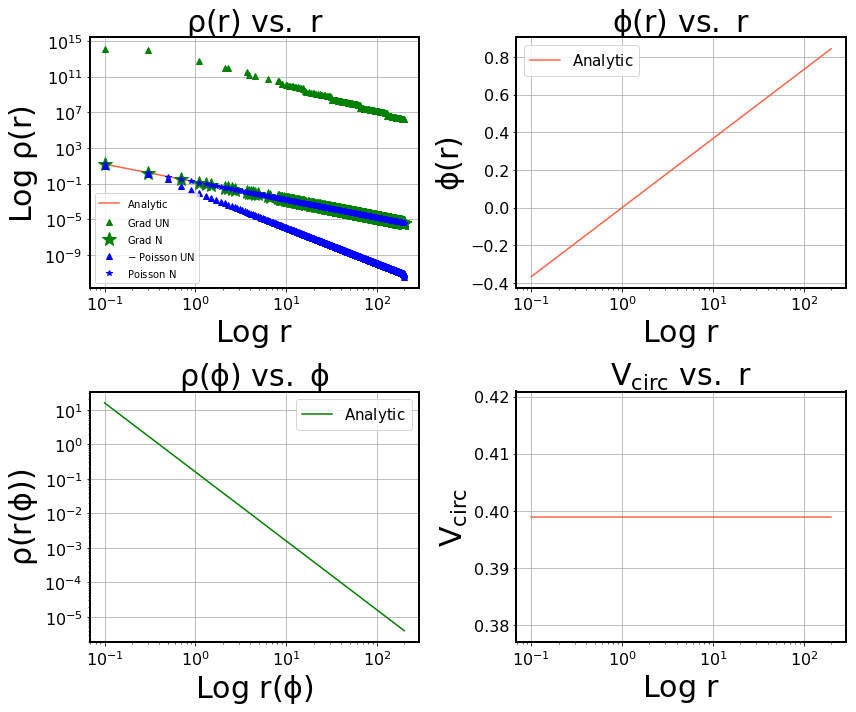

In [27]:
# create figure object
fig = plt.figure(4)
fig.set_figheight(10)
fig.set_figwidth(12)

# create axis object
ax = plt.subplot(221)
plt.grid(True)

# ploting
plt.plot(r_iso, rho_of_r_analytic, 'tomato', label=r'$\mathrm{Analytic}$')
plt.plot(r_iso_unnormalized, dphi2_dr2_grad_unnormalized,
         'g^', label=r'$\mathrm{Grad\ UN}$')
plt.plot(r_iso_normalized, dphi2_dr2_grad_normalized,
         'g*', markersize=15, label=r'$\mathrm{Grad\ N}$')
plt.plot(r_iso_poisson_unnormalized, -dphi2_dr2_grad_poisson_unnormalized,
         'b^', label=r'$\mathrm{-\ Poisson\ UN}$')
plt.plot(r_iso_poisson_normalized, dphi2_dr2_grad_poisson_normalized,
         'b*', label=r'$\mathrm{Poisson\ N}$')
# plt.plot(rho_of_r_diff, drho_dr_diff,'r*',label=r'$\mathrm{np.diff}$')


# labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r) }$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=10)
plt.tight_layout()


# create axis space
ax = plt.subplot(222)
plt.grid(True)

# ploting
plt.plot(r_iso, phi_of_r_analytic_iso,
         color='tomato', label=r'$\mathrm{Analytic}$')
# plt.plot(r_array_2,rho_computational_py(r_array_2),label=r'$\mathrm{Computational}$')

# labeling
plt.title(r'$\mathrm{\phi(r)\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{\phi(r)}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()


# create axis space
ax = plt.subplot(223)
plt.grid(True)

# ploting
# plt.plot(phi_iso_sphere_of_r_analytic_py(r_array_2),rho_iso_sphere_of_phi_analytic_py(r_array_2),
#          color='tomato',label=r'$\mathrm{Analytic}$')
plt.plot(r_of_phi_iso, rho_of_r_of_phi_iso,
         color='green', label=r'$\mathrm{Analytic}$')

# plt.plot(r_array_2,rho_computational_py(r_array_2),label=r'$\mathrm{Computational}$')

# labeling
plt.title(r'$\mathrm{\rho(\phi)\ vs.\ \phi}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r(\phi)}$', size=30)
plt.ylabel(r'$\mathrm{\rho (r(\phi))}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

# create axis space
ax = plt.subplot(224)
plt.grid(True)

# ploting
plt.plot(r_array_2, vcirc_iso_sphere_of_r_analytic(r_array_2), color='tomato')
# plt.plot(r_array_2,rho_computational_py(r_array_2),label=r'$\mathrm{Computational}$')

# labeling
plt.title(r'$\mathrm{V_{circ}\ vs.\ r}$', size=30)
plt.xlabel(r'$\mathrm{Log\ r}$', size=30)
plt.ylabel(r'$\mathrm{V_{circ}}$', size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogx()
# plt.legend(fontsize=15)
plt.tight_layout()

### iso Sphere: Density vs potential and it's derivatives

#### variables for plotting

In [29]:
# first derivative
r_first_deriv, drho_dr  = take_deriv(rho_iso_sphere_of_r_analytic(r_array_2),_x=r_array_2,_n=1)

# second derivative
r_second_derive, d2rho_dr2  = take_deriv(rho_iso_sphere_of_r_analytic(r_array_2),_x=r_array_2,_n=2)

/Users/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


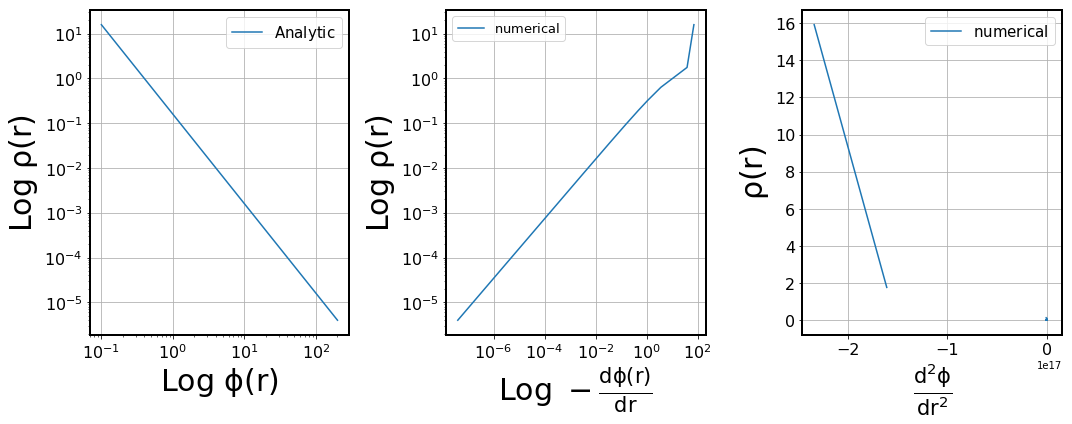

In [30]:
fig = plt.figure(3)
fig.set_figheight(6)
fig.set_figwidth(15)

#create axis object
ax = plt.subplot(131)
plt.grid(True)

##ploting
plt.plot(r_iso, rho_of_r_analytic,
         label=r'$\mathrm{Analytic}$')

#labeling
# plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
plt.xlabel(r'$\mathrm{Log\ \phi (r)}$',size=30)
plt.ylabel(r'$\mathrm{Log\ \rho(r) }$',size=30)

ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

#create axis object
ax = plt.subplot(132)
plt.grid(True)

##ploting
plt.plot(-drho_dr,rho_of_r_analytic,label=r'$\mathrm{numerical}$')

#labeling
# plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
plt.xlabel(r'$\mathrm{Log\ -\frac{\mathrm{d} \phi(r)}{\mathrm{d}r}}$',size=30)
plt.ylabel(r'$\mathrm{Log\ \rho(r) }$',size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=13)
plt.tight_layout()

ax = plt.subplot(133)
plt.grid(True)


##ploting
plt.plot(d2rho_dr2, rho_of_r_analytic,label=r'$\mathrm{numerical}$')

#labeling
# plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
plt.xlabel(r'$\mathrm{\frac{\mathrm{d}^2 \phi}{\mathrm{d}r^2}}$',size=30)
plt.ylabel(r'$\mathrm{\rho(r) }$',size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
# plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

# plt.xlabel(r'$\mathrm{\frac{\mathrm{d}^2 \omega}{\mathrm{d}\theta^2}}$',size=30)

# Plummer Potential; All constants 1 except for pi 

## Symbolic math for Plummer sphere density & potentials, to put into functions.. 

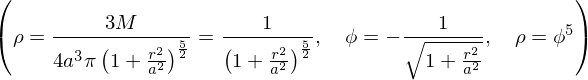

In [31]:
r_plum, a_plum, M_plum = sp.symbols(('r', 'a', 'M'), evaluate=False)
plummer_constants = sp.Mul(3, M_plum, evaluate=False) / \
    sp.Mul(4*pi, pow(a_plum, 3), evaluate=False)
expr_plum = plummer_constants * \
    pow((1+pow((r_plum/a_plum), 2)), sp.Rational(-5/2))
expr_plum2 = pow((1+pow((r_plum/a_plum), 2)), sp.Rational(-5/2))

rho_eq_plum = sp.Eq(rho, expr_plum, evaluate=False)
rho_eq_plum = sp.Eq(rho_eq_plum, expr_plum2, evaluate=False)
# phi_eq_plum = sp.integrate(sp.integrate(rho_eq_plum,r),r)
# phi_eq_plum_int = sp.Eq(phi, phi_eq_plum,evaluate=True)

phi_eq_plum_int = pow((1+pow((r_plum/a_plum), 2)), sp.Rational(-1/2))
phi_eq_plum = sp.Eq(phi, -1*phi_eq_plum_int, evaluate=False)


rho_eq_plum_2 = sp.Eq(rho, phi**5, evaluate=False)

rho_eq_plum, phi_eq_plum, rho_eq_plum_2

## Analytic Plummer Functions

In [32]:
# PLUMMER SPHERE ##### PHI (r) ### ANALYTIC EQ
def phi_plum_sphere_of_r_analytic(_r, _a_plum=1, _Grav_const=1, _M=1):
    calc = -1*pow((1+pow((_r/_a_plum), 2.0)), -1/2)
    return calc

# PLUMMER SPHERE ##### RHO (r) ### ANALYTIC EQ


def rho_plum_sphere_of_r_analytic(_r, _a_plum=1, _Grav_const=1, _M=1):
    calc = (3 * _M)/(4*np.pi) * pow((1.0+pow((_r/_a_plum), 2.0)), -5/2)
    return calc

# PLUMMER SPHERE ##### RHO (phi) ### ANALYTIC EQ


def rho_plum_sphere_of_phi_analytic(_r, phi_func=phi_plum_sphere_of_r_analytic, _Grav_const=1, _M=1):
    calc = np.abs(-1*phi_func(_r)**5.0)
    return calc


# PLUMMER SPHERE ##### r (phi) ### ANALYTIC EQ
def r_plum_sphere_of_phi_analytic(_r, phi_func=phi_iso_sphere_of_r_analytic, _a_plum=1, _Grav_const=1, _M=1):
    calc = _a_plum*np.sqrt((phi_func(_r)**-2.0) - 1.0)
    return calc

# PLUMMER SPHERE ##### Vcirc (r) ### ANALYTIC EQ


def vcirc_plum_sphere_of_r_analytic(_r, _a_plum=1, _Grav_const=1, _M=1):
    holder = np.zeros(_r.size)
    constants = _r * pow((1+pow((_r/_a_plum), 2)), -3/4)
    return holder + constants

## Numerical Plummer Functions (poisson + derivatives)

In [33]:
# PLUMMER SPHERE ##### RHO (r) ### Numerical EQ


def rho_plum_sphere_of_r_numerical(_r, _phi_func=phi_plum_sphere_of_r_analytic,
                                   _rho_func=rho_plum_sphere_of_r_analytic, _deriv_func=take_deriv,
                                   p_a_plum=1, p_Grav_const=1, p_M=1, _normalize=False):
    """
    This function takes as input:
    input array _r (radius)
    phi_func = analytic phi(_r) equation
    rho_func = analytic rho(_r) equation (for normalizing)
    _deriv_func = derivative function for taking derivative (uses np.grad to get 2nd deriv)
    the rest are constants

    Outputs an array containing the inputs _r and numerical rho(r); shape (len(_r),2)

    _normalize determines whethr or not you want numerical rho to be normalized by the analytic
    expression
    if true the outputs become are still _r and
    numerical rho(r) but the shape is now (len(_r[np.isfinite(numerical rho(r))]),2)
    this happens because this function currently blows up close to 0 due to logs/exponentials


    """

    # calc phi (r)
    _phi = _phi_func(_r, _a_plum=p_a_plum, _Grav_const=p_Grav_const, _M=p_M)

    # Get second derivative
    _, _d2phi_dr2 = _deriv_func(_function_array=_phi, _x=_r, _n=2)

    # Poisson Constants
    _poisson_constants = (4*np.pi*p_Grav_const)

    # divide by constants to get rho numerically
    _calc = _d2phi_dr2 / _poisson_constants

    # define input array for returning
    _r_output = _r

    if _normalize == True:
        analytic_rho = _rho_func(_r, _a_plum=p_a_plum,
                                 _Grav_const=p_Grav_const, _M=p_M)

        # Normalization Constant
        normalization_constant = _calc[np.isfinite(
            _calc)] / analytic_rho[np.isfinite(_calc)]

        # Normalize and account for infs/nans
        _r_output, _calc = _r_output[np.isfinite(
            _calc)], _calc[np.isfinite(_calc)]/normalization_constant

    return np.array((_r_output, _calc))

# PLUMMER SPHERE ##### RHO (r) ### Numerical EQ


def rho_plum_sphere_of_r_poisson_numerical(_r, _phi_func=phi_plum_sphere_of_r_analytic,
                                           _rho_func=rho_plum_sphere_of_r_analytic,
                                           _poisson_deriv_func=rho_solver_for_phi_of_r_poisson,
                                           _this_deriv_func=take_deriv, p_a_plum=1, p_Grav_const=1,
                                           p_M=1, _normalize=False):
    """
    This function takes as input:
    input array _r (radius)
    phi_func = the specified phi function
    rho_func = analytic rho(_r) function (for normalizing) 
    _deriv_func = Poisson function for taking derivative (which makes use of take_dir for derivatives)
    the rest are constants

    Outputs an array containing the inputs _r and numerical rho(r); shape (len(_r),2)

    _normalize determines whethr or not you want numerical rho to be normalized by the analytic
    expression
    if true the outputs become are still _r and
    numerical rho(r) but the shape is now (len(_r[np.isfinite(numerical rho(r))]),2)
    this happens because this function currently blows up close to 0 due to logs/exponentials


    """

    # get _r output and numerical rho from poisson solver
    _r_output, _calc = _poisson_deriv_func(_r, _phi_func, _deriv_func=_this_deriv_func,
                                           _a_plum=p_a_plum, _Grav_const=p_Grav_const,
                                           _M=p_M)

    if _normalize == True:
        analytic_rho = _rho_func(_r, _a_plum=p_a_plum,
                                 _Grav_const=p_Grav_const, _M=p_M)

        # Normalization Constant
        normalization_constant = _calc[np.isfinite(
            _calc)] / analytic_rho[np.isfinite(_calc)]

        # Normalize and account for infs/nans
        _r_output, _calc = _r_output[np.isfinite(
            _calc)], _calc[np.isfinite(_calc)]/normalization_constant

    return np.array((_r_output, _calc))

### Variables for plotting 

In [34]:
# r of phi
r_plum, phi_of_r_analytic_plum = r_array_2, phi_plum_sphere_of_r_analytic(
    r_array_2)

# rho of r
r_plum, rho_of_r_analytic = r_array_2, rho_plum_sphere_of_r_analytic(r_array_2)

# phi of r and derivatives

# Grad unnormalized
r_plum_unnormalized, dphi2_dr2_grad_unnormalized = rho_plum_sphere_of_r_numerical(
    r_plum, _phi_func=phi_plum_sphere_of_r_analytic, _rho_func=rho_plum_sphere_of_r_analytic,
    _deriv_func=take_deriv, p_a_plum=1, p_Grav_const=1, p_M=1, _normalize=False)

# Grad unnormalized
r_plum_normalized, dphi2_dr2_grad_normalized = rho_plum_sphere_of_r_numerical(
    r_plum, _phi_func=phi_plum_sphere_of_r_analytic, _rho_func=rho_plum_sphere_of_r_analytic,
    _deriv_func=take_deriv, p_a_plum=1, p_Grav_const=1, p_M=1, _normalize=True)

# Poisson normalized
r_plum_poisson_normalized, dphi2_dr2_grad_poisson_normalized = rho_plum_sphere_of_r_poisson_numerical(
    r_plum, _phi_func=phi_plum_sphere_of_r_analytic, _rho_func=rho_plum_sphere_of_r_analytic,
    _poisson_deriv_func=rho_solver_for_phi_of_r_poisson, _this_deriv_func=take_deriv, p_a_plum=1,
    p_Grav_const=1, p_M=1, _normalize=True)

# Poisson unnormalized
r_plum_poisson_unnormalized, dphi2_dr2_grad_poisson_unnormalized = rho_plum_sphere_of_r_poisson_numerical(
    r_plum, _phi_func=phi_plum_sphere_of_r_analytic, _rho_func=rho_plum_sphere_of_r_analytic,
    _poisson_deriv_func=rho_solver_for_phi_of_r_poisson, _this_deriv_func=take_deriv, p_a_plum=1,
    p_Grav_const=1, p_M=1, _normalize=False)

# r of phi stuff
r_of_phi_plum, rho_of_r_of_phi_plum = r_plum_sphere_of_phi_analytic(
    r_array_2), rho_plum_sphere_of_r_analytic(_r=r_plum_sphere_of_phi_analytic(r_array_2))

/Users/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


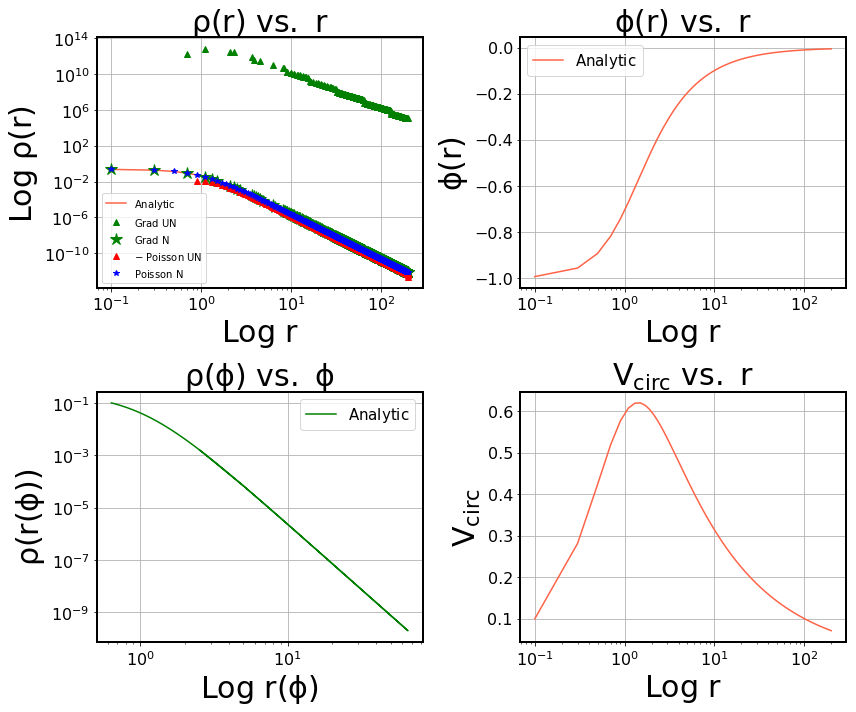

In [35]:
#create figure object
fig = plt.figure(4)
fig.set_figheight(10)
fig.set_figwidth(12)

#create axis object
ax = plt.subplot(221)
plt.grid(True)

##ploting
plt.plot(r_plum, rho_of_r_analytic,'tomato',label=r'$\mathrm{Analytic}$')
plt.plot(r_plum_unnormalized, dphi2_dr2_grad_unnormalized,'g^',label=r'$\mathrm{Grad\ UN}$')
plt.plot(r_plum_normalized, dphi2_dr2_grad_normalized,'g*',markersize=12,label=r'$\mathrm{Grad\ N}$')
plt.plot(r_plum_poisson_unnormalized, -dphi2_dr2_grad_poisson_unnormalized,'r^',label=r'$\mathrm{-\ Poisson\ UN}$')
plt.plot(r_plum_poisson_normalized, dphi2_dr2_grad_poisson_normalized,'b*',label=r'$\mathrm{Poisson\ N}$')
# plt.plot(rho_of_r_diff, drho_dr_diff,'r*',label=r'$\mathrm{np.diff}$')


#labeling
plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
plt.xlabel(r'$\mathrm{Log\ r}$',size=30)
plt.ylabel(r'$\mathrm{ Log\ \rho(r) }$',size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=10)
plt.tight_layout()


#create axis space
ax = plt.subplot(222)
plt.grid(True)

##ploting
plt.plot(r_plum, phi_of_r_analytic_plum,color='tomato',label=r'$\mathrm{Analytic}$')
# plt.plot(r_array_2,rho_computational_py(r_array_2),label=r'$\mathrm{Computational}$')

#labeling
plt.title(r'$\mathrm{\phi(r)\ vs.\ r}$',size=30)
plt.xlabel(r'$\mathrm{Log\ r}$',size=30)
plt.ylabel(r'$\mathrm{\phi(r)}$',size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()


#create axis space
ax = plt.subplot(223)
plt.grid(True)

##ploting
# plt.plot(phi_plum_sphere_of_r_analytic_py(r_array_2),rho_plum_sphere_of_phi_analytic_py(r_array_2),
#          color='tomato',label=r'$\mathrm{Analytic}$')
plt.plot(r_of_phi_plum, rho_of_r_of_phi_plum ,
         color='green',label=r'$\mathrm{Analytic}$')

# plt.plot(r_array_2,rho_computational_py(r_array_2),label=r'$\mathrm{Computational}$')

#labeling
plt.title(r'$\mathrm{\rho(\phi)\ vs.\ \phi}$',size=30)
plt.xlabel(r'$\mathrm{Log\ r(\phi)}$',size=30)
plt.ylabel(r'$\mathrm{\rho (r(\phi))}$',size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

#create axis space
ax = plt.subplot(224)
plt.grid(True)

##ploting
plt.plot(r_array_2,vcirc_plum_sphere_of_r_analytic(r_array_2),color='tomato')
# plt.plot(r_array_2,rho_computational_py(r_array_2),label=r'$\mathrm{Computational}$')

#labeling
plt.title(r'$\mathrm{V_{circ}\ vs.\ r}$',size=30)
plt.xlabel(r'$\mathrm{Log\ r}$',size=30)
plt.ylabel(r'$\mathrm{V_{circ}}$',size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogx()
# plt.legend(fontsize=15)
plt.tight_layout()




### Plummer: Density vs potential and it's derivatives

In [37]:
# first derivative
r, drho_of_r_dr_r = take_deriv(
    phi_plum_sphere_of_r_analytic(r_array_2), _x=r_array_2, _n=1)

# second derivative
r, d2rho_of_r_dr_r2 = take_deriv(
    phi_plum_sphere_of_r_analytic(r_array_2), _x=r_array_2, _n=2)

/Users/michael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


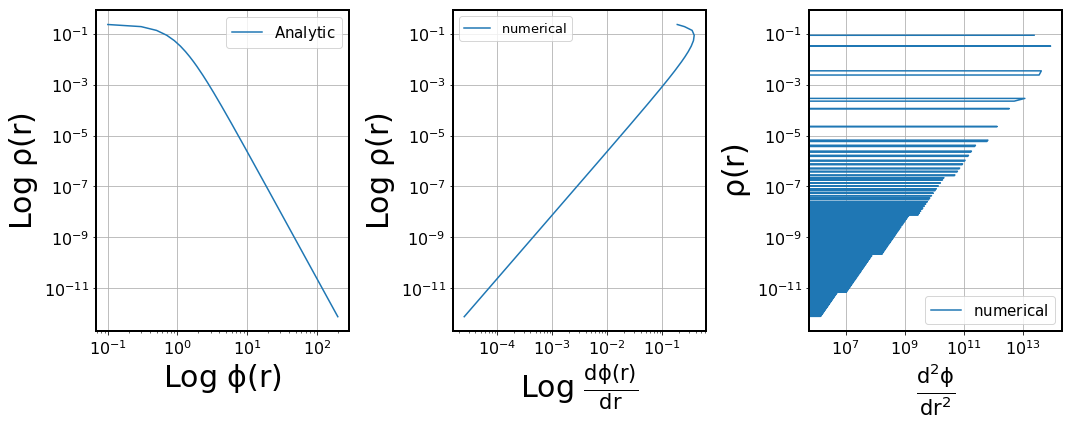

In [38]:
fig = plt.figure(3)
fig.set_figheight(6)
fig.set_figwidth(15)

#create axis object
ax = plt.subplot(131)
plt.grid(True)

##ploting
plt.plot(r_plum, rho_of_r_analytic,
         label=r'$\mathrm{Analytic}$')

#labeling
# plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
plt.xlabel(r'$\mathrm{Log\ \phi (r)}$',size=30)
plt.ylabel(r'$\mathrm{Log\ \rho(r) }$',size=30)

ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

#create axis object
ax = plt.subplot(132)
plt.grid(True)

##ploting
plt.plot(drho_of_r_dr_r,rho_of_r_analytic,label=r'$\mathrm{numerical}$')

#labeling
# plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
plt.xlabel(r'$\mathrm{Log\ \frac{\mathrm{d} \phi(r)}{\mathrm{d}r}}$',size=30)
plt.ylabel(r'$\mathrm{Log\ \rho(r) }$',size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=13)
plt.tight_layout()

ax = plt.subplot(133)
plt.grid(True)


##ploting
plt.plot(d2rho_of_r_dr_r2, rho_of_r_analytic,label=r'$\mathrm{numerical}$')

#labeling
# plt.title(r'$\mathrm{\rho(r)\ vs.\ r}$',size=30)
plt.xlabel(r'$\mathrm{\frac{\mathrm{d}^2 \phi}{\mathrm{d}r^2}}$',size=30)
plt.ylabel(r'$\mathrm{\rho(r) }$',size=30)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
plt.semilogy()
plt.semilogx()
plt.legend(fontsize=15)
plt.tight_layout()

# plt.xlabel(r'$\mathrm{\frac{\mathrm{d}^2 \omega}{\mathrm{d}\theta^2}}$',size=30)